## Levatamos Fermionic

In [1]:
!pip install openfermion sparse ray cupy-cuda12x cloudpickle scikit-learn openfermionpyscf

Debido al número de niveles (innecesarios) en el core, el objetivo es calcular la base natural (a partir de rho1), y proyectar el fundamental sobre el subespacio generado por los estados no ocupados. Allí, buscamos la descomposición, y luego volvemos a la base original

In [2]:
from fermionic_mbody import FixedBasis, rho_m
from fermionic_mbody.rho import rho_m_gen_legacy as rho_m_gen

import numpy as np
import openfermion as of
from tqdm import tqdm
from itertools import combinations
from openfermion.utils import commutator, count_qubits, hermitian_conjugated
import functools
import concurrent.futures
from numba import njit
import scipy
import sparse
import itertools
import linecache
from multiprocessing import Pool, cpu_count
import sympy

## Determinación de estado

#### Calculo de H

In [3]:
"""
Un método alternativo para el caso H2O para calcular los hamiltonianos en función de (d), utilizando pyscf
"""

from openfermion.chem import MolecularData
import matplotlib.pyplot as plt
import openfermionpyscf

def generate_h2o_hamiltonian(r):
    theta = np.deg2rad(104.5)
    x, z = r * np.sin(theta/2), r * np.cos(theta/2)
    geometry = [
        ('O', (0.0, 0.0, 0.0)),
        ('H', ( x, 0.0, z)),
        ('H', (-x, 0.0, z))
    ]
    
    molecule_s = MolecularData(
        geometry=geometry,
        basis='sto-3g',
        multiplicity=1,
        charge=0
    )
    
    molecule = openfermionpyscf.run_pyscf(
        molecule_s,
        run_scf=1,
        run_mp2=1,
        run_cisd=1,
        run_ccsd=1,
        run_fci=1
    )

    molecular_hamiltonian = molecule.get_molecular_hamiltonian()
    
    qubit_hamiltonian = of.jordan_wigner(molecular_hamiltonian)
    
    sparse_hamiltonian = of.get_sparse_operator(qubit_hamiltonian)
    
    return sparse_hamiltonian, molecule, molecule_s


#### Inicialización de bases y arrays básicos

In [4]:
# Base en el canónico
basis_c = FixedBasis(d=14, num=10) 

# Filtramos a los estados que tengan igual número de electrones UP / DOWN
idx_equal = [
    idx for idx, ket in enumerate(basis_c.base)
    if sum(p % 2 == 0 for p, _ in next(iter(ket.terms.keys()))) == 5
]
basis_r = FixedBasis.from_subset(basis_c, idx_equal)

# Base de 5 partículas (solo UP)
basis_up = FixedBasis(d=7, num=5) 

In [5]:
# Dado un operador, devulve los niveles UP o DOWN que tiene ocupados
def split_indices(op, basis = basis_up):
    # occupation bit-masks for the 7 up and 7 down spin-orbitals
    mask_up, mask_dn = 0, 0
    for p, _ in next(iter(op.terms.keys())):       # p = 0…13
        if p % 2 == 0:                             # even → ↑
            mask_up |= 1 << (p // 2)               # shift into 0…6
        else:                                      # odd  → ↓
            mask_dn |= 1 << (p // 2)

    i = int(np.where(basis.num_ele == mask_up)[0][0])
    j = int(np.where(basis.num_ele == mask_dn)[0][0])
    return i, j

sub2idx = {} # Mapea índices (UP_IDX, DOWN_IDX) -> índice en basis_r
for k, op in enumerate(basis_r.base):
    i_up , j_dn = split_indices(op, basis_up)      
    sub2idx[(i_up , j_dn)] = k

# Devuelve C_{ij} tal que  |GS⟩ = Σ_{i,j} C_ij |UP_i⟩⊗|DOWN_j⟩."""
def vect_to_tensor_array(vect, basis_r, basis_up, up = False):
    C = np.zeros((basis_up.size, basis_up.size), dtype=vect.dtype)

    if vect.ndim == 1:
        for k, amp in enumerate(vect):
            if np.abs(amp) == 0:
                continue
            i, j = split_indices(basis_r.base[k], basis_up)
            C[i, j] = amp

        return C
    else:
        prod_dim = basis_up.size
        reorder  = np.empty(prod_dim**2, dtype=int)
        for i in range(prod_dim):
            for j in range(prod_dim):
                reorder[i*prod_dim + j] = sub2idx[(i, j)] 

        rho_perm = vect[np.ix_(reorder, reorder)]   
        rho4D    = rho_perm.reshape(prod_dim, prod_dim,
                                    prod_dim, prod_dim)
        if up:     
            rho_res   = np.trace(rho4D, axis1=1, axis2=3)
        else:  
            rho_res   = np.trace(rho4D, axis1=0, axis2=2)  

        return rho_res

"""
Dada matriz densidad de 1 cuerpo, calcula la base natural de 1 cuerpo.
Devuelve la matriz densidad en la nueva base
"""
def natural_basis_rotation(basis, rho_1 = None, U = None):
    if U is None:
        evals, evects = scipy.linalg.eigh(rho_1.todense())
        U = evects[::-1].T 

    V = np.zeros((basis.size, basis.size))
    
    act_lvls = lambda tt: [tpl[0] for tpl in next(iter(tt.terms.keys()))]
    i_levels = np.array([act_lvls(basis.base[i]) for i in range(basis.size)])
    j_levels = np.array([act_lvls(basis.base[j]) for j in range(basis.size)])
    
    row_indices = i_levels[:, np.newaxis, :, np.newaxis]
    col_indices = j_levels[np.newaxis, :, np.newaxis, :]

    submatrices = U[row_indices, col_indices]
    V = np.linalg.det(submatrices)
    
    return V


### Optimización de representación

Comenzamos obteniendo el fundamental

In [10]:
# Obtenemos el Hamiltoniano en el límite disociado (escrito en el GC)
h_gc, _, _ = generate_h2o_hamiltonian(3.0)
h_c = h_gc[np.ix_(basis_r.num_ele, basis_r.num_ele)].real.todense()
e, v = scipy.sparse.linalg.eigsh(h_c, k=1, which='SA', tol=1e-8)
fund = v[:, 0]

# Construimos la base reduciuda y la matriz C
C = vect_to_tensor_array(fund, basis_r, basis_up)

# Arrays
rho_1_arrays = rho_m_gen_legacy(basis_up, 1)

# Arrancamos rotando a la base natural
rho_up = C @ np.transpose(C)
rho_down = np.transpose(C) @ C
# Calculo matrices densidad 1 cuerpo
rho_1_up = rho_m(rho_up, rho_1_arrays)
rho_1_down = rho_m(rho_down, rho_1_arrays)
# Matrices de cambio de base (UP DOWN) y transformacion rho -> rhon
V_up = natural_basis_rotation(basis_up, rho_1 = rho_1_up)
rhon_up = V_up @ rho_up @ V_up.T
V_down = natural_basis_rotation(basis_up, rho_1 = rho_1_down)
rhon_down = V_down @ rho_down @ V_down.T
Cn = V_up @ C @ V_down.T

ρ_1: 100%|██████████| 12/12 [00:00<00:00, 168.41it/s]


In [ ]:
rho_1_arrays.size

In [7]:
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.cluster.vq import kmeans, vq
from sklearn.mixture import GaussianMixture
from scipy.linalg import expm, logm

"""
Dado un estado C, busca rotaciones de un cuerpo que minimizen el número de términos presentes en el estado. Para ello
- Dado un vector seed (generador de la matriz antisimétrica), obtenemos una transformación U via exponenciación
- Calculamos el cambio de base, y la representación de rho en esa nueva base
- Calculamos el costo de la representacion
"""
# Comenzaremos con la optimización con la base natural
def rho_to_seed(rho):
    evals, evects = scipy.linalg.eigh(rho.todense())
    U = evects[::-1].T 
    return encode(U)

def encode(U):
    A = logm(U) 
    A = 0.5 * (A - A.T) 
    triu_indices = np.triu_indices(U.shape[0], k=1)
    params = A[triu_indices].real  
    return params

def decode(params):
    n = int((1 + np.sqrt(1 + 8 * len(params))) // 2) 
    A = np.zeros((n, n))
    triu_indices = np.triu_indices(n, k=1)
    A[triu_indices] = params
    A -= A.T  
    U = expm(A) 
    return U

# Funciones de costo

def hoyer_sparsity(c):
    n = c.size
    L1 = np.sum(np.abs(c))
    L2 = np.sqrt(np.sum(c**2))
    return (np.sqrt(n) - L1 / L2) / (np.sqrt(n) - 1)


def l0_combined(C, threshold=1e-3, alpha=0.1, beta=1.0, temperature=0.01):
    abs_C = np.abs(C)
    L1 = np.sum(abs_C)
    sigmoid_mask = 1 / (1 + np.exp(-(abs_C - threshold) / temperature))
    smoothed_L0 = np.sum(sigmoid_mask)
    
    return alpha * L1 + beta * smoothed_L0

def loss(C):
    """
    Distintas normas utilizadas para optimizar. Estas verifican 
    -OK1 => que loss(C) > loss(Cn)
    -OK2 => nonzero(Cn) > nonzero(Cop)
    """
    # Hoyer (OK2)
    #return 1 - hoyer_sparsity(C.flatten())
    # Norma 1 (OK1)
    #return np.linalg.norm(C, 1)
    # Norma infinito (OK1)
    # return np.max(np.sum(abs(C), axis=1))
    # Combined L0 + penalty loss (OK1) (OK2)
    return l0_combined(C)

def opti_fun(seed, C = C, basis = basis_up):
    # Decodificamos la semilla
    params_up, params_down = seed[:len(seed)//2], seed[len(seed)//2:] 
    # Decodificamos 
    U_up, U_down = decode(params_up), decode(params_down)
    V_up, V_down = natural_basis_rotation(basis, U=U_up), natural_basis_rotation(basis, U=U_down)
    # Obtenemos la matriz de coeficientes rotada
    Ce = V_up @ C @ V_down.T
    return loss(Ce)

# Calculo de semilla
seed_up = rho_to_seed(rho_1_up)
seed_down = rho_to_seed(rho_1_down)
init_seed = np.concatenate([seed_up, seed_down])


# Optimizamos
opt_m = scipy.optimize.basinhopping(
    opti_fun,
    init_seed,
    niter=10,
    T=1.0,
    stepsize=0.5,
    minimizer_kwargs={
        "method":"L-BFGS-B",
        "options":{"disp": True}
    },
)

# Rotamos el estado
#seed = opt_m.x
#params_up, params_down = seed[:len(seed)//2], seed[len(seed)//2:] 
#U_up, U_down = decode(params_up), decode(params_down)
#Vop_up, Vop_down = natural_basis_rotation(basis_up, U=U_up), natural_basis_rotation(basis_up, U=U_down)
#Cop = Vop_up @ C @ Vop_down.T

In [8]:
#ooo = 2
#len(np.round(C,ooo).nonzero()[0]), len(np.round(Cn,ooo).nonzero()[0]), len(np.round(Cop,ooo).nonzero()[0])
#loss(C), loss(Cn), loss(Cop)

## Calculo de matrices densidad (en función de d)

#### Generación de arrays UPUP/UPDOWN

In [6]:
"""
Genera lo subbloques de rho_2_arrays dado por los pares c^\dag_p c^\dag_q c_s c_r
    El parámetro ordered antisimetriza los índices, correspondiendo a operadores de
    FixedBasis(d, 2). Si no, es simplemente d^4 resahapeado (repetidos)
    ordered=True  →  shape (d², d², …)
    rho2_block_antisym →  shape (C(d,2), C(d,2), …)
    
    upup define a qué subbloque apuntamos
"""
from typing import List, Tuple

def _extract_sparse_block(arr: sparse.COO, row_terms, col_terms) -> sparse.COO:
    row_mask = np.isin(arr.coords[0], row_terms)
    col_mask = np.isin(arr.coords[1], col_terms)
    keep = row_mask & col_mask

    coords = arr.coords[:, keep]
    data   = arr.data[keep]

    row_map = {old: new for new, old in enumerate(row_terms)}
    col_map = {old: new for new, old in enumerate(col_terms)}
    coords[0] = np.fromiter((row_map[x] for x in coords[0]), int)
    coords[1] = np.fromiter((col_map[x] for x in coords[1]), int)

    shape = (len(row_terms), len(col_terms), arr.shape[2], arr.shape[3])
    return sparse.COO(coords, data, shape)


def rho2_block_antisym(basis, rho2_full = None, upup=True):
    if rho2_full is None:
        rho2_full = rho_m_gen(basis, 2)

    t_basis = FixedBasis(basis.d, 2)
    terms   = []
    for idx, op in enumerate(t_basis.base):
        p, q = (lvl for lvl, _ in next(iter(op.terms.keys())))
        if upup:
            if (p % 2 == 0 and q % 2 == 0) or (p % 2 == 1 and q % 2 == 1):
                terms.append(idx)
        else:
            if (p % 2) != (q % 2):
                terms.append(idx)

    return _extract_sparse_block(rho2_full, terms, terms)


def so_idx(spatial, spin):             # spin = 0(↑) or 1(↓)
    return 2*spatial + spin            # even = ↑ , odd = ↓

def _rho2_ext_worker(chunk, basis, sig, tau):
    coords, vals = [], []
    d     = basis.d // 2
    for i, j, k, l in chunk:           # all spatial indices 0 … d-1
        i, j, k, l = map(int, (i, j, k, l))

        op1 = of.FermionOperator( (so_idx(k, sig), 1) ) * \
              of.FermionOperator( (so_idx(l, tau), 1) )
        op2 = of.FermionOperator( (so_idx(j, tau), 0) ) * \
              of.FermionOperator( (so_idx(i, sig), 0) )

        mat = np.real(
                of.get_sparse_operator(op1 * op2,
                                        n_qubits = 2 * d)   # 2·d spin-orbitals
              )[basis.num_ele, :][:, basis.num_ele]
        
        r, c = mat.nonzero()
        row, col = i * d + j, k * d + l
        for rr, cc, vv in zip(r, c, mat.data):
            coords.append([row, col, rr, cc])
            vals.append(vv)
    return coords, vals



def rho2_block_ordered(basis, upup=True, n_workers=None):

    if n_workers is None:
        n_workers = max(1, cpu_count()//2)

    d     = basis.d // 2
    shape = (d**2, d**2, basis.size, basis.size)

    # keep ONE spin ordering
    if upup:
        spin_cases = [(0, 0)]                 # ↑↑ (or ↓↓)
    else:
        spin_cases = [(0, 1)]                 # ↑↓  only ONE ordering


    work   = list(itertools.product(range(d), repeat=4))
    chunks = np.array_split(work, n_workers)

    coords, vals = [], []

    for sig, tau in spin_cases:
        if n_workers == 1:
            for chunk in tqdm(chunks, desc="ρ₂-ordered"):
                c, v = _rho2_ext_worker(chunk, basis, sig, tau)
                coords.extend(c); vals.extend(v)
        else:
            with Pool(n_workers) as pool:
                jobs = ((chunk, basis, sig, tau) for chunk in chunks)
                for c, v in tqdm(pool.starmap(_rho2_ext_worker, jobs),
                                total=n_workers, desc="ρ₂-ordered"):
                    coords.extend(c); vals.extend(v)

    coords = np.asarray(coords).T
    return sparse.COO(coords, vals, shape)



# Operaciones sobre matrices
def partial_traspose(rho, perm, upup = True):
    d = basis_up.d
    rho_p = np.zeros((d**2, d**2))
    f = 0 if upup else d
    for m in range(d**2):
        for n in range(d**2):
            # Escrimos los índices i j k l en términos de m n
            i, j = m//d, m % d
            k, l = n//d, n % d
            indices = (i, j, k, l)
            ip, jp, kp, lp = tuple(indices[p] for p in perm)
            rho_p[m,n] = rho[ip*d + jp, kp*d + lp]
    return rho_p


# Generación de arrays
rho_1_extended = rho_m_gen(basis_r, 1)
rho_2_extended = rho_m_gen(basis_r, 2)
rho_2_extended_upup_as = rho2_block_antisym(basis_r, rho_2_extended, upup=True)
rho_2_extended_updown_as = rho2_block_antisym(basis_r, rho_2_extended, upup=False)
rho_2_extended_upup = rho2_block_ordered(basis_r, upup=True)
rho_2_extended_updown = rho2_block_ordered(basis_r, upup=False)


ρ₂-ordered: 100%|██████████| 6/6 [00:00<00:00, 1997.13it/s]


#### Cálculo de estados

In [ ]:
dists = np.linspace(0.11, 4.11, 50)
vects = {}

prev_vec = None
for R in tqdm(dists, desc="GS"):
    H_full, *_ = generate_h2o_hamiltonian(R)
    H = H_full[np.ix_(basis_r.num_ele, basis_r.num_ele)].real
    E, V = scipy.sparse.linalg.eigsh(H, k=1, which='SA', v0=prev_vec, tol=1e-10)

    # Fundamental
    vec  = V[:, 0]
    vects[R] = vec
    prev_vec = vec / np.linalg.norm(vec)

    # Termico
    beta = 1000
    weights = np.exp(-beta * (E - E.min()))     
    weights /= weights.sum() 
    vects[R] = (V @ np.diag(weights)) @ V.conj().T

GS: 100%|██████████| 50/50 [07:09<00:00,  8.59s/it]


#### Ploteo en función de d

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_43731/122628309.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  res[idx] = np.sort(np.linalg.eigvals(rho.todense()))
100%|██████████| 50/50 [00:00<00:00, 472.46it/s]


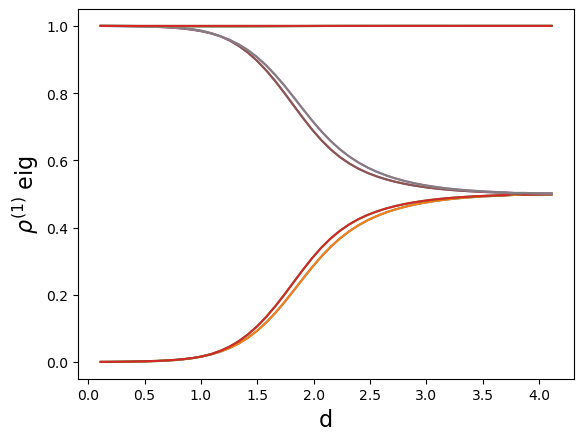

100%|██████████| 50/50 [00:00<00:00, 67.43it/s]


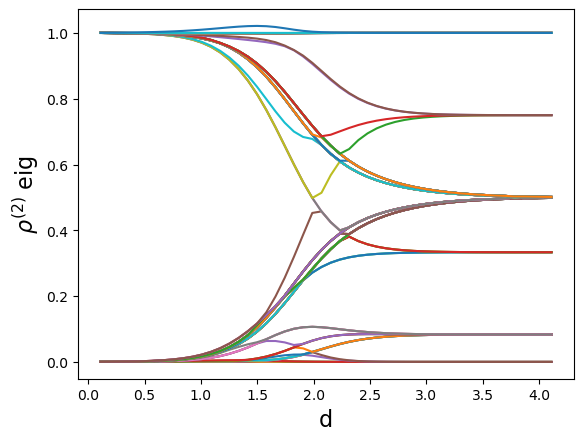

100%|██████████| 50/50 [00:00<00:00, 170.09it/s]


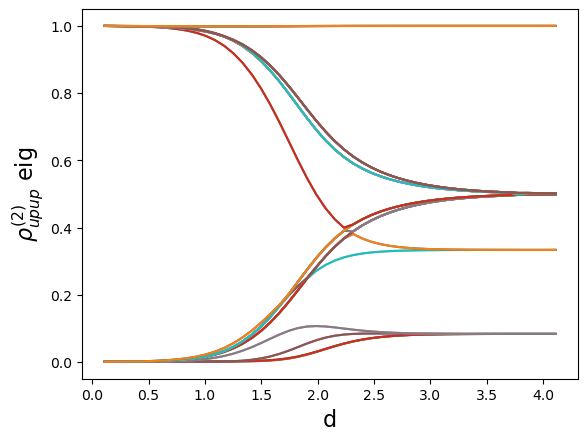

100%|██████████| 50/50 [00:00<00:00, 91.82it/s]


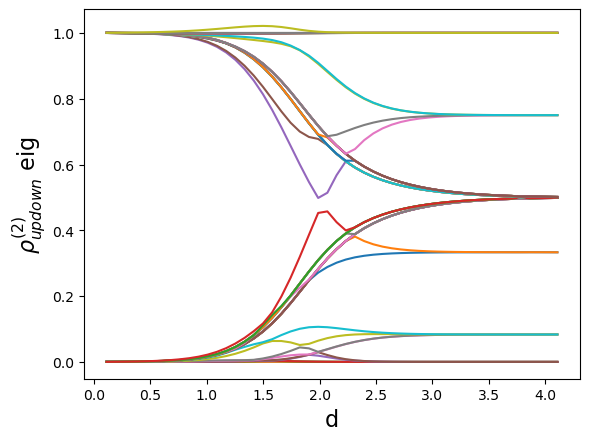

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_43731/122628309.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  res[idx] = np.sum([x for x in np.linalg.eigvals(rho) if x<0])
100%|██████████| 50/50 [00:05<00:00,  8.67it/s]


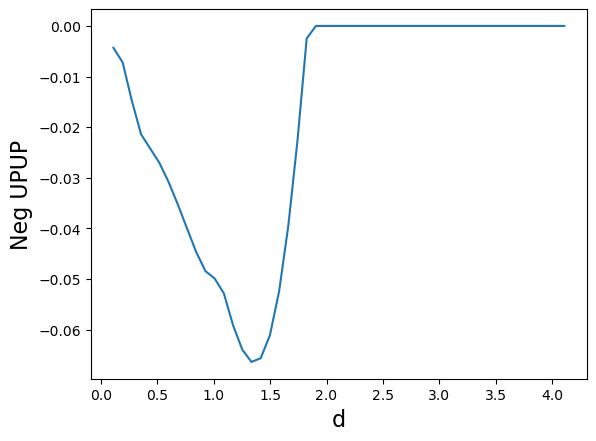

100%|██████████| 50/50 [00:03<00:00, 15.51it/s]


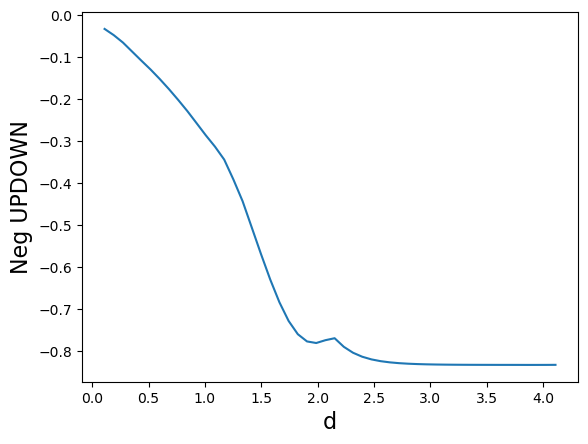

array([-0.03308218, -0.04791903, -0.06562565, -0.08718087, -0.10870074,
       -0.12975319, -0.15247412, -0.17657964, -0.20220101, -0.22893508,
       -0.25760988, -0.28647684, -0.31352204, -0.34430181, -0.3917572 ,
       -0.44345925, -0.50634025, -0.56942577, -0.62985523, -0.68415564,
       -0.72863834, -0.76021675, -0.77743874, -0.78118616, -0.77447033,
       -0.76978994, -0.79028136, -0.80437805, -0.81387405, -0.8202134 ,
       -0.82444297, -0.82727775, -0.82919087, -0.83049129, -0.83138086,
       -0.83199255, -0.83241353, -0.83270463, -0.83290588, -0.83304568,
       -0.83313772, -0.83320026, -0.83324338, -0.83328844, -0.83329101,
       -0.83331962, -0.83337645, -0.83335219, -0.83330827, -0.83318591])

In [16]:
import matplotlib.pyplot as plt

def plot_rho(vects, rho_arrays, label = r'$\rho^{(m)}$ eig'):
    ds = list(vects.keys())
    res = np.zeros(shape=(len(ds),rho_arrays.shape[0]))
    for idx, d in tqdm(enumerate(ds), total=len(ds)):
        vect = vects[d]
        rho = rho_m(vect, rho_arrays)
        res[idx] = np.sort(np.linalg.eigvals(rho.todense()))

    plt.plot(ds, res)
    plt.xlabel(r'd', fontsize=16)
    plt.ylabel(label, fontsize=16)
    plt.show()
    return res

def m_entropy(vects, rho_arrays):
    ds = list(vects.keys())
    res = np.zeros(shape=(len(ds)))
    for idx, d in tqdm(enumerate(ds), total=len(ds)):
        vect = vects[d]
        rho = rho_m(vect, rho_arrays)
        eigvals = np.sort(np.linalg.eigvals(rho.todense()))
        res[idx] = -np.sum([x * np.log2(x) for x in eigvals])
    return res / np.trace(rho.todense())

def plot_neg(vects, rho_arrays, label = r'$\rho^{(m)}$ eig', second = False):
    ds = list(vects.keys())
    res = np.zeros(shape=(len(ds)))
    for idx, d in tqdm(enumerate(ds), total=len(ds)):
        vect = vects[d]
        rho = rho_m(vect, rho_arrays)
        second_term = partial_traspose(rho, [0, 2, 3, 1]) if second else 0
        rho = partial_traspose(rho, [0, 3, 2, 1]) - second_term
        #print(np.sort(np.linalg.eigvals(rho)))
        res[idx] = np.sum([x for x in np.linalg.eigvals(rho) if x<0])

    plt.plot(ds, res)
    plt.xlabel(r'd', fontsize=16)
    plt.ylabel(label, fontsize=16)
    plt.show()
    return res

def plot_density_up(vects): # Thermal states
    prod_dim = basis_up.size
    reorder  = np.empty(prod_dim**2, dtype=int)

    ds = list(vects.keys())
    res = np.zeros(shape=(len(ds), basis_up.size))
    for idx, d in tqdm(enumerate(ds), total=len(ds)):

        for i in range(prod_dim):
            for j in range(prod_dim):
                reorder[i*prod_dim + j] = sub2idx[(i, j)] 

        rho = np.array(vects[d])
        rho_perm = rho[np.ix_(reorder, reorder)]   
        rho4D    = rho_perm.reshape(prod_dim, prod_dim,
                                    prod_dim, prod_dim)     
        rho_up   = np.trace(rho4D, axis1=1, axis2=3)  

        res[idx] = np.sort(np.linalg.eigvals(rho_up))

    plt.plot(ds, res)
    plt.xlabel(r'd', fontsize=16)
    plt.ylabel( r'$\rho_{UP}$ eig', fontsize=16)
    plt.show()
    return res

#plot_density_up(vects)

plot_rho(vects, rho_1_extended, label = r'$\rho^{(1)}$ eig')
plot_rho(vects, rho_2_extended, label = r'$\rho^{(2)}$ eig')
plot_rho(vects, rho_2_extended_upup_as, label = r'$\rho^{(2)}_{upup}$ eig')
plot_rho(vects, rho_2_extended_updown_as, label = r'$\rho^{(2)}_{updown}$ eig')
plot_neg(vects, rho_2_extended_upup, label = r'Neg UPUP', second = True)
plot_neg(vects, rho_2_extended_updown, label = r'Neg UPDOWN')

#ds = list(vects.keys())
#plt.plot(ds, m_entropy(vects, rho_1_extended),label='Total (1)')
#plt.plot(ds, m_entropy(vects, rho_2_extended),label='Total (2)')
#plt.plot(ds, m_entropy(vects, rho_2_extended_upup), label='UPUP')
#plt.plot(ds, m_entropy(vects, rho_2_extended_updown), label='UPDOWN')
#plt.legend()
#plt.show()


## Análisis H

In [10]:
# Generamos el H para d=4
H_sparse, molecule, molecule_s = generate_h2o_hamiltonian(4)
# Restringimos a la base canónica
H_sparse = H_sparse[np.ix_(basis_c.num_ele, basis_c.num_ele)].real

In [11]:
# Filtramos a los estados que tengan igual número de electrones UP / DOWN
idx_equal = [
    idx for idx, ket in enumerate(basis_c.base)
    if sum(p % 2 == 0 for p, _ in next(iter(ket.terms.keys()))) == 5
]

H = H_sparse[np.ix_(idx_equal, idx_equal)].todense()
# Guardamos la base restringida
basis_r = FixedBasis.from_subset(basis_c, idx_equal)
rho_1_arrays_r = rho_1_extended
rho_2_arrays_r = rho_2_extended

In [12]:
# Veamos los primeros autovalores
eigvals, eigvects = np.linalg.eigh(H)
# Levantamos el autoespacio fundamental
tol = 1e-2
idx = np.where(eigvals < min(eigvals)+tol)
dimension = len(idx[0])
eigen_space = eigvects[:,idx[0]] # Las columnas de eigen_space son las distintos estados fundamentales en basis_r (441, 12)

Verificamos que el autoespacio tenga el spin correcto

In [ ]:
import openfermion as of
import numpy as np
from scipy.sparse.linalg import eigsh
bbb = basis_r

# This assumes you have num_orbitals, num_electrons already defined
sz_op = of.hamiltonians.sz_operator(bbb.d//2)
s2_op = of.hamiltonians.s_squared_operator((1+bbb.d)//2)

sz_op = of.get_sparse_operator(sz_op, n_qubits=bbb.d)[np.ix_(bbb.num_ele, bbb.num_ele)]
s2_op = of.get_sparse_operator(s2_op, n_qubits=bbb.d)[np.ix_(bbb.num_ele, bbb.num_ele)]

for i in range(eigen_space.shape[1]):
    state = eigen_space[:,i]
    exp_S2 = np.real(state.conj().T @ (s2_op @ state))
    exp_Sz = np.real(state.conj().T @ (sz_op @ state))
    print(f"Estado {i}: <S^2> = {float(exp_S2):.4f}, <S_z> = {float(exp_Sz):.4f}")


##### Subespacio pureza nula

Utilizamos L-BFGS-B para buscar mínimos locales, a partir de distintas semillas. Con una colección de estos, nos fijamos el rango de subespacio

In [13]:
def purity(coefs):
    vect = np.asarray(eigen_space @ coefs).ravel()   
    vect /= np.linalg.norm(vect)
    rho_1 = rho_m(vect, rho_1_arrays_r).todense()
    return basis_r.m-np.trace(np.linalg.matrix_power(rho_1, 2))

maxiter = 50
local_minima_arr = []

for i in tqdm(range(maxiter)):
    seed = np.random.uniform(-1,1,dimension)
    seed *= 1/np.linalg.norm(seed)
    opt = scipy.optimize.minimize(purity, seed, method="SLSQP", constraints={'type':'eq', 'fun': lambda c: c@c-1})
    if purity(opt.x) < 1e-4:
        local_minima_arr.append(opt.x)

local_minima_arr = np.array(local_minima_arr).T # [:, i] i-esimo vector
U, S, Vh  = np.linalg.svd(local_minima_arr)
idx = np.where(S > 1e-2)
purity_dim = len(idx[0])
purity_space = U[:,idx[0]] # purity_space[:, i] i-ésimo generador en la base eigen_space (12, 6)


100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


Dado purity_space, existe una base ortonormal que la genere también?

In [20]:
# Buscamos el espacio ortonormal
Q, R = np.linalg.qr(purity_space)
diag_R = np.abs(np.diag(R))
rank   = np.sum(diag_R > 1e-12)
purity_space_ort = Q[:, :rank] # base ortonormal de purity_space escrita en eigen_space

n, k = purity_space_ort.shape
tri_u = np.triu_indices(k, 1)         
n_free = len(tri_u[0])                 

"""
Vía QR, obtuvimos un conjunto de generadores ortonormales de purity_space. En principio, no tienen porque ser DS
Procedemos buscando transformaciones unitarias que hagan que el conjunto de generadores tenga pureza mínima
"""

# Parametrización del la antisimétrica (exponente)
def param_to_A(theta: np.ndarray) -> np.ndarray:
    A = np.zeros((k, k), dtype=float)
    A[tri_u] = theta
    A[(tri_u[1], tri_u[0])] = -theta 
    return A                           

# Devuelve las coordenadas de un vector en la base de pureza, a basis_r
def purity_to_basis(coefs):
    vect = np.asarray(eigen_space @ coefs).ravel()   
    vect /= np.linalg.norm(vect)
    return vect

# Pureza del conjunto
def loss(coefs, fun):
    res = 0
    for j in range(purity_space_ort.shape[1]):
        vect = fun(coefs[:,j])
        rho_1 = rho_m(vect, rho_1_arrays_r).todense()
        res += basis_r.m-np.trace(np.linalg.matrix_power(rho_1, 2))
    return res

# Función a minimizar
def total_purity(theta: np.ndarray, B: np.ndarray, fun) -> float:
    A = param_to_A(theta)
    U = scipy.linalg.expm(A)           
    rot_gen = B @ U
    return loss(rot_gen, fun)

theta0 = np.zeros(n_free)                              

res = scipy.optimize.minimize(
    total_purity,
    theta0,
    args=(purity_space_ort,purity_to_basis,),
    method="BFGS",
    options=dict(disp=True, maxiter=2000),
)
res


Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 1
         Function evaluations: 48
         Gradient evaluations: 3


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.4277747784063877e-06
        x: [-1.943e-05 -1.665e-05 ...  1.490e-08 -2.681e-05]
      nit: 1
      jac: [-2.384e-07 -1.192e-07 ...  7.153e-07 -1.192e-07]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 48
     njev: 3

Comprobamos que ambos proyectores coincidan

In [17]:
A_opt  = param_to_A(res.x)          
U_opt  = scipy.linalg.expm(A_opt) 
coeffs_rot = purity_space_ort @ U_opt      
purity_kets   = eigen_space @ coeffs_rot 

In [18]:
vect_unif = np.sum([1/np.sqrt(purity_dim) * purity_kets[:,j] for j in range(purity_dim)], axis=0).reshape(-1)
au = lambda x: np.sort(np.linalg.eigvals(x.todense()))

au(rho_m(vect_unif, rho_1_arrays_r))


array([0.49854606, 0.49885552, 0.49981124, 0.49989497, 0.50010505,
       0.50018876, 0.50114451, 0.50145398, 0.99999996, 0.99999997,
       0.99999998, 0.99999999, 1.        , 1.        ])

##### Subespacio pureza nula (basado en ops)


In [ ]:
import itertools
import numpy as np
import openfermion as of
from fermionic_mbody._ofsparse import number_preserving_matrix, restrict_sector_matrix   # sparse helper :contentReference[oaicite:0]{index=0}

# ----------------------------------------------------------------------
# (1) build the single–particle SWAP operator  S₁  on TWO copies
# ----------------------------------------------------------------------
def swap_1body(d: int) -> of.FermionOperator:
    """
    Return  S₁ = Σ_{p,q} c†_{p,1} c_{q,1} c†_{q,2} c_{p,2}
    The first copy uses modes 0…d-1, the second copy d…2d-1.
    """
    swap = of.FermionOperator()
    for p, q in itertools.product(range(d), repeat=2):
        swap += of.FermionOperator(
            ((p, 1),           # c†_{p,1}
             (q, 0),           # c_{q,1}
             (q + d, 1),       # c†_{q,2}
             (p + d, 0))       # c_{p,2}
        )
    return of.transforms.normal_ordered(swap)

# ----------------------------------------------------------------------
# (2) sparse matrix in the |N₁=N₂=m〉 sector  (N = 2m electrons total)
# ----------------------------------------------------------------------
d, m = 14, 10                        # ← your system
S1 = swap_1body(d)

# build the sparse matrix **directly** in the 20-electron sector
S1_mat = number_preserving_matrix(S1, 2*d, 2*m)      # :contentReference[oaicite:1]{index=1}

left  = np.repeat(basis_r.num_ele, basis_r.size)      # 441² masks
right = np.tile  (basis_r.num_ele, basis_r.size)
subset_masks = left | (right << d)                   # bit-shift 2nd copy by +d
S1_sub = restrict_sector_matrix(S1_mat, subset_masks, 2*d, 2*m)

# ----------------------------------------------------------------------
# (3) prepare the product state  |ψ⊗ψ〉   in the SAME basis ordering
# ----------------------------------------------------------------------
#  original  N=m  basis and ground state vector  (dim = 441)
psi = np.asarray(eigen_space[:, -1]).ravel()
psi /= np.linalg.norm(psi)

psi2 = np.kron(psi, psi)
tr_rho1_sq = (psi2.conj() @ (S1_sub @ psi2)).real

print(tr_rho1_sq)

rrr = rho_m(psi, rho_1_arrays_r).todense()
rrr = np.linalg.matrix_power(rrr, 2)
print(np.trace(rrr))

7.999904670044885
7.9999046700448915


In [152]:
left  = np.repeat(basis_r.num_ele, basis_r.size)      # 441² masks
right = np.tile  (basis_r.num_ele, basis_r.size)
subset_masks = left | (right << d)                   # bit-shift 2nd copy by +d

from fermionic_mbody._ofsparse import number_preserving_matrix, restrict_sector_matrix   # sparse helper :contentReference[oaicite:0]{index=0}

# ------------------------------------------------------------------
# 4) project down to 194 481 × 194 481
# ------------------------------------------------------------------
S1_sub = restrict_sector_matrix(S1_mat, subset_masks, 2*d, 2*m)

# ------------------------------------------------------------------
# 5) product-state vector |ψ⟩⊗|ψ⟩ in the *same* ordering
# ------------------------------------------------------------------
psi3 = np.random.uniform(0,1,441)
psi3 /= np.linalg.norm(psi3)
psi2 = np.kron(psi3, psi3)      # length 441² = 194 481

rrr = rho_m(psi3, rho_1_arrays_r).todense()
rrr = np.linalg.matrix_power(rrr, 2)
print(np.trace(rrr))
# ------------------------------------------------------------------
# 6) expectation value  Tr ρ₁²
# ------------------------------------------------------------------
tr_rho1_sq = (psi2.conj() @ (S1_sub @ psi2)).real
print(f"Tr rho1^2 via swap test: {tr_rho1_sq:.10f}")

7.326274262463608
Tr rho1^2 via swap test: 7.3262742625


In [ ]:
# ----------------------------------------------------------
# (3) change basis: from Slater-determinant ⊗ Slater-determinant
#     to   {|ψ_a〉⊗|ψ_b〉},  a,b = 1…12
# ----------------------------------------------------------
# matrix whose columns are the ground states  |ψ_i〉   (441×12)
E = eigen_space

# Kronecker basis change:   B  = kron(E, E)        (size 441² × 144)
B = np.kron(E, E)          # explicit; dimension is small (441² × 144)

# project S₁ to the 12×12×12×12 subspace
S1_proj = B.conj().T @ (S1_sub @ B)      # 144 × 144

# ----------------------------------------------------------
# (4) work in the symmetric subspace  |ψ〉⊗|ψ〉
#     index map  (a,b) with a≤b   →   row
# ----------------------------------------------------------
pairs   = [(a,b) for a in range(12) for b in range(a,12)]
row_for = {p:k for k,p in enumerate(pairs)}
dim_sym = len(pairs)                    # = 78

S_sym = np.zeros((dim_sym, dim_sym), dtype=float)

for (a, b), r in row_for.items():
    f_ab = 1.0 if a == b else 1/np.sqrt(2.0)

    col  = a*12 + b
    colT = b*12 + a

    for (c, d), s in row_for.items():
        f_cd = 1.0 if c == d else 1/np.sqrt(2.0)

        row  = c*12 + d
        rowT = d*12 + c

        S_sym[r, s] = f_ab * f_cd * (
             S1_proj[col , row ] + S1_proj[colT, row ]
           + S1_proj[col , rowT] + S1_proj[colT, rowT] ).real
        
# ----------------------------------------------------------
# (5) eigen-decomposition inside that symmetric space
# ----------------------------------------------------------
eigvals, W = np.linalg.eigh(S_sym)

# those with eigenvalue  ≈ m  give Tr ρ₁² = m  →  purity 0
tol = 1e-5
idx_p0 = np.where(np.abs(eigvals - m) < tol)[0]     # should find 6 of them
#print(eigvals)
#print("eigenvalues near m =", eigvals[idx_p0])

# ----------------------------------------------------------
# (6) recover the coefficient vector c  (12 components)
#     from the eigenvector  w  (78 components)
# ----------------------------------------------------------
tol_eig   = 1e-6          # closeness of ⟨S₁⟩ to m
tol_rank  = 1         # rank-1 threshold

idx_m  = np.where(np.abs(eigvals - m) < tol_eig)[0]
phi_kets = []

for v in W[:, idx_m].T:                 # loop over the 9 candidates
    # --- build C with the √2 factor --------------------------------
    C = np.zeros((12, 12))
    for (a, b), r in row_for.items():
        if a == b:
            C[a, a] = v[r]                 # w_aa = c_a²
        else:
            C[a, b] = C[b, a] = v[r] / np.sqrt(2.0)   # w_ab = √2 c_a c_b

    # --- rank-1 check ----------------------------------------------
    s = np.linalg.svd(C, compute_uv=False)
    if s[1] / s[0] > tol_rank:          # not rank-1 → skip
        print(s[1]/ s[0])
        continue

    # --- extract the single-particle coefficients c -----------------
    u, s_full, _ = np.linalg.svd(C)
    c = u[:, 0] * np.sqrt(s_full[0])

    ket = (eigen_space @ c).ravel()
    ket /= np.linalg.norm(ket)
    phi_kets.append(ket)

print(f'kept {len(phi_kets)} purity-0 kets')   # 6

# ----------------------------------------------------------
# (7) sanity check: orthonormality, purity = 0
# ----------------------------------------------------------

phi_kets = np.array(phi_kets).reshape(6,441)
print(phi_kets.shape)
phi_kets = np.stack(phi_kets, axis=1)     # 441 × 6

for k in range(6):
    rho1 = rho_m(phi_kets[:,k], rho_1_arrays_r).todense()
    print(np.linalg.eigvals(rho1))
    print(f"k = {k:2d}   purity  =  {m - np.trace(rho1@rho1).real:9.2e}")

In [223]:
W[:, idx_m].T.shape

(6, 78)

In [221]:
vect_unif = np.sum([1/np.sqrt(6) * phi_kets[:,j] for j in range(purity_dim)], axis=0).reshape(-1)
vect_unif /= np.linalg.norm(vect_unif)
au = lambda x: np.sort(np.linalg.eigvals(x.todense()))

au(rho_m(vect_unif, rho_1_arrays_r))


array([0.40002827, 0.40002997, 0.40003517, 0.40003757, 0.59996245,
       0.59996485, 0.59997006, 0.59997176, 0.99999997, 0.99999997,
       0.99999998, 0.99999999, 1.        , 1.        ])

In [250]:
vect = np.zeros(441**2)
B = np.kron(E,E)
for i in range(441**2):
    for j in range(12**2):
        vect += B[i,0] * np.kron(basis_r.canonicals[i // 441], basis_r.canonicals[0])



vect


KeyboardInterrupt: 

##### Subespacio pureza no nula

Repetimos para el espacio ortonormal a purity_space

In [33]:
Q, R = np.linalg.qr(purity_space, mode="complete")
ort_space = Q[:, purity_dim:]

def ort_to_basis(coefs):
    vect_e = np.sum([coefs[i] * ort_space[:,i] for i in range(ort_space.shape[1])], axis=0)
    vect = np.sum([vect_e[i] * eigen_space[:,i] for i in range(dimension)], axis=0)
    vect_n = vect * 1/np.linalg.norm(vect)
    return vect_n.T[0]

res = scipy.optimize.minimize(
    total_purity,
    theta0,
    args=(purity_space_ort,ort_to_basis,),
    method="BFGS",
    options=dict(disp=True, maxiter=2000),
)


Optimization terminated successfully.
         Current function value: 6.096869
         Iterations: 90
         Function evaluations: 1616
         Gradient evaluations: 101


Análisis de bloques rho_2

In [20]:
# Ortogonales a purity
ort_space_dim = ort_space.shape[1]
for k in range(ort_space_dim):
    vect_e = ort_space[:,k]
    vect = np.array(np.sum([vect_e[i] * eigen_space[:,i] for i in range(dimension)], axis=0)).reshape(-1)
    rho = rho_m(vect, rho_2_extended_updown).todense()
    #second_term = partial_traspose(rho, [0, 2, 3, 1])
    #rho = partial_traspose(rho, [0, 3, 2, 1]) - second_term
    au = np.sort(np.linalg.eigvals(rho).real)
    #print(au)

print(au)
len(np.where(np.abs(au-1) < 0.1)[0]), len(np.where(np.abs(au-1/2) < 0.1)[0])


[1.05691980e-08 1.27862496e-08 1.29145174e-08 3.86917707e-03
 7.73834925e-03 7.73838047e-03 2.46016323e-01 2.46018253e-01
 2.46037498e-01 2.46037534e-01 2.53962340e-01 2.53964247e-01
 2.53983856e-01 2.53983895e-01 4.91982407e-01 4.92012689e-01
 4.92012705e-01 4.92013726e-01 4.92013743e-01 4.92017522e-01
 4.96165505e-01 4.99996244e-01 4.99996249e-01 4.99997150e-01
 5.00002714e-01 5.00002719e-01 5.00003969e-01 5.03833381e-01
 5.03844342e-01 5.03844345e-01 5.03853672e-01 5.03853676e-01
 5.07981919e-01 5.08005511e-01 5.08005528e-01 5.08009449e-01
 5.08009471e-01 5.08018239e-01 9.92259657e-01 9.92261602e-01
 9.96128863e-01 9.96130761e-01 9.96130777e-01 9.96130804e-01
 9.96130819e-01 9.99999983e-01 9.99999984e-01 9.99999985e-01
 1.00000000e+00]


(11, 24)

Análisis mat. dens. UP

In [ ]:
def vect_to_up(vect):
    C = vect_to_tensor_array(vect, basis_r, basis_up) 
    return C @ np.transpose(C)

# Función a minimizar
def total_tr(theta: np.ndarray, B: np.ndarray) -> float:
    A = param_to_A(theta)
    U = scipy.linalg.expm(A)           
    rot_r = B @ U
    return loss(rot_r)

# Pureza del conjunto
def loss(coefs):
    res = 0
    for j in range(purity_space_ort.shape[1]):
        vect = ort_to_basis(coefs[:,j])
        C = vect_to_up(vect)
        res += np.trace(C)-np.trace(np.linalg.matrix_power(C, 2))
    return res

theta0 = np.zeros(n_free)                              
res = scipy.optimize.minimize(
    total_tr,
    theta0,
    args=(purity_space_ort,),
    method="BFGS",
    options=dict(disp=True, maxiter=2000),
)

Optimization terminated successfully.
         Current function value: 3.486013
         Iterations: 86
         Function evaluations: 1456
         Gradient evaluations: 91


#### Otros análisis

Análisis de descomposición de Schmidt

100%|██████████| 50/50 [00:03<00:00, 13.85it/s]


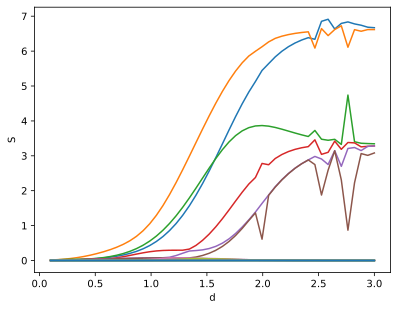

In [ ]:
"""
Para cada autoestado, calculamos la descomposición de Schmidt
"""

prod_dim = basis_up.size           
ds       = sorted(vects)           
res      = np.zeros((len(ds), prod_dim))

for idx, d in tqdm(list(enumerate(ds)), total=len(ds)):
    gs_vec = vects[d]
    # Schmidt decomp
    C = vect_to_tensor_array(gs_vec, basis_r, basis_up)   
    U, s, Vh = np.linalg.svd(C, full_matrices=False)
    V = Vh.conj().T

    # Recontruimos cada uno de los términos de GS |φ_ν⟩ = s_ν Σ_{i,j} U_{iν} V_{jν} |i↑⟩⊗|j↓⟩
    for nu in range(prod_dim):
        phi = np.zeros_like(gs_vec)
        for i in range(prod_dim):
            if U[i, nu] == 0: continue
            for j in range(prod_dim):
                if V[j, nu] == 0: continue
                k = sub2idx[(i, j)] # A qué elemento de la base corresponde?
                phi[k] += s[nu] * U[i, nu] * V[j, nu]

        rho1_nu = rho_m(phi, rho_1_arrays_r)                 
        eig = np.linalg.eigvalsh(rho1_nu.todense()).real
        eig = eig[eig > 1e-12]                   
        res[idx, nu] = -np.sum(eig * np.log2(eig))

plt.xlabel('d')
plt.ylabel('S')
plt.plot(ds, res)

Información mútua

100%|██████████| 50/50 [00:00<00:00, 77.65it/s]


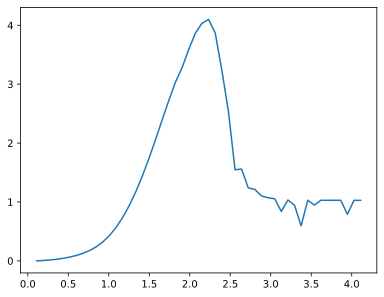

In [26]:
prod_dim = basis_up.size           
ds       = sorted(vects)           
res      = np.zeros((len(ds)))

def S(rho):
    eigvals = np.linalg.eigvalsh(rho)
    return -np.sum([x * np.log2(x) for x in eigvals if x > 1e-6])

for idx, d in tqdm(list(enumerate(ds)), total=len(ds)):
    rho = np.array(vects[d])
    rho_up = vect_to_tensor_array(rho, basis_r, basis_up, up = True)
    rho_down = vect_to_tensor_array(rho, basis_r, basis_up, up = False)
    rho_1_up = rho_m(rho_up, rho_1_arrays).todense()
    rho_1_up *= np.trace(rho_1_up)
    rho_1_down = rho_m(rho_down, rho_1_arrays).todense()
    rho_1_down *= np.trace(rho_1_down)
    rho_2_updown = rho_m(rho, rho_2_extended_updown_as).todense()

    res[idx] = S(rho_1_up) + S(rho_1_down) - S(rho_2_updown)
    #res[idx] = S(rho_up) + S(rho_down) - S(rho)

plt.plot(ds, res-res[0])

In [18]:
res[-1]-res[0]

1.0276599236894697

In [16]:
1/2*(-37 + 10*np.log2(15))

1.0344529780425944

Negatividad de los distintos bloques

In [72]:
pp_idx = np.zeros((6,441))
for i in range(6):
    pp_idx[i] = np.sum([purity_space[k,i] * eigen_space[:,k] for k in range(12)], axis=0).flatten()

A = np.array(pp_idx).T
opp = A @ np.linalg.inv(A.T @ A) @ A.T

np.round(opp,4)

array([[ 0., -0., -0., ..., -0.,  0.,  0.],
       [-0.,  0.,  0., ...,  0.,  0., -0.],
       [-0.,  0.,  0., ...,  0., -0., -0.],
       ...,
       [-0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0., -0., ..., -0.,  0., -0.],
       [ 0., -0., -0., ...,  0., -0.,  0.]])

In [102]:
diag_elem = np.where(np.abs(opp) > 1e-1)[0]
for i in range(6):
    act_lvls = lambda tt: [tpl[0] for tpl in next(iter(tt.terms.keys()))] # Consistente con lo anterior
    print(6.5-np.array(act_lvls(basis_r.base[diag_elem[i]]))/2)
    #print(basis_r.base[diag_elem[i]])


[6.5 6.  5.  4.  3.5 3.  2.5 1.5 0.5 0. ]
[6.  5.5 5.  4.  3.5 3.  2.5 1.5 0.5 0. ]
[6.  5.  4.5 4.  3.5 3.  2.5 1.5 0.5 0. ]
[6.5 6.  5.5 4.5 3.5 3.  2.  1.  0.5 0. ]
[6.5 5.5 5.  4.5 3.5 3.  2.  1.  0.5 0. ]
[6.5 5.5 4.5 4.  3.5 3.  2.  1.  0.5 0. ]


In [ ]:
U, S, Vh  = np.linalg.svd(local_minima_arr)
idx = np.where(S > 1e-2)
purity_dim = len(idx[0])
purity_space = U[:,idx[0]]

coefs = np.sum([1 * purity_space[:,i] for i in range(purity_dim)], axis=0)
vect = np.sum([coefs[i] * eigen_space[:,i] for i in range(dimension)], axis=0)
vect = np.array(vect).flatten()
vect *= 1/np.linalg.norm(vect)


# Construimos la base reduciuda y la matriz C
C = vect_to_tensor_array(basis, vect)

# Arrancamos rotando a la base natural
rho_up = C @ np.transpose(C)
rho_down = np.transpose(C) @ C

#rho = rho_m(vect, rho_2_extended_updown)
#rho = partial_traspose(rho, [0, 3, 2, 1]) 
#print(np.sort(np.linalg.eigvals(rho)))



In [ ]:
def decomp(coefs):
    coefs = np.sum([coefs[i] * purity_space[:,i] for i in range(purity_dim)], axis=0)
    vect = np.sum([coefs[i] * eigen_space[:,i] for i in range(dimension)], axis=0)
    vect = vect.T[0]
    vect *= 1/np.linalg.norm(vect)
    rho_1 = rho_m(vect, rho_1_arrays_r).todense()
    return 1-np.trace(np.linalg.matrix_power(rho_1, 2))

opt2 = scipy.optimize.minimize(decomp, np.random.rand(purity_dim))
ooo = opt2.x
print(opt2)
ooo *= 1/np.linalg.norm(ooo)
print(ooo)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -8.999999778160634
        x: [ 1.041e+00  1.335e+00  2.288e-06  5.717e-01  7.936e-07
            -6.305e-07]
      nit: 6
      jac: [ 0.000e+00  4.768e-07  7.153e-07  0.000e+00  4.768e-07
            -8.345e-07]
 hess_inv: [[ 1.274e+00  3.514e-01 ... -6.656e-02 -1.304e-02]
            [ 3.514e-01  1.451e+00 ... -8.613e-02 -1.564e-02]
            ...
            [-6.656e-02 -8.613e-02 ...  4.171e-01  2.714e-01]
            [-1.304e-02 -1.564e-02 ...  2.714e-01  5.390e-01]]
     nfev: 77
     njev: 11
[ 5.82635519e-01  7.47071848e-01  1.28071271e-06  3.20030477e-01
  4.44251153e-07 -3.52981057e-07]


Transpuesta parcial sobre el proyector al autoespacio. Recordar que utilizamos la convención de OF, donde los índices pares son UP y los impares DOWN

In [ ]:
from sympy.combinatorics import Permutation



# Reescribimos los elementos de la base en términos de productos tensorial
up_lvls = []
down_lvls = []
act_lvls = lambda tt: np.array([tpl[0] for tpl in next(iter(tt.terms.keys()))])
for op in basis_r.base:
    up_lvls.append(tuple(sorted(l for l in act_lvls(op) if l % 2 == 0)))
    down_lvls.append(tuple(sorted(l for l in act_lvls(op) if l % 2 == 1)))

# Filtramos los elemetos únicos, obteniendo la base de un lado del producto tensorial
u_up_lvls = np.array(list(set(up_lvls)))
u_down_lvls = np.array(list(set(down_lvls)))

# Obtenemos la matrix C_{\mu\nu}
def tensor_decomp(state):
    s = len(u_up_lvls)
    C = np.zeros((s,s))
    act_to_int = lambda x: np.sum([2**i for i in x])
    for i, j in itertools.product(range(s), repeat=2):
        targ_state_pre = np.concatenate([u_up_lvls[i], u_down_lvls[j]])
        targ_state = tuple(sorted(targ_state_pre))
        r_idx = np.where(basis_r.num_ele == act_to_int(targ_state))[0]
        # Calculamos el signo de la permutación al sortearlos
        perm = np.argsort(targ_state_pre)
        p = Permutation(list(perm))
        sign = p.signature()
        C[i, j] = sign * state[r_idx]

    return C

def partial_transpose(C):
    s = len(u_up_lvls)
    res = np.zeros((s**2,s**2))
    for mu, nu, mup, nup in itertools.product(range(s), repeat=4):
        i = s * mu + nu
        j = s * mup + nup
        res[i, j] = C[mu, nup] * C[mup, nu]
    return res

pt = lambda x: partial_transpose(tensor_decomp(x))
mat = np.sum([pt(eigen_space[:,i]) for i in range(dimension)], axis=0)
np.sort(np.linalg.eigvals(mat))

/tmp/ipykernel_36865/1646309796.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C[i, j] = sign * state[r_idx]


array([-9.99999916e-01, -9.99999916e-01, -1.87175042e-04, -1.87171684e-04,
       -1.73404358e-04, -1.73238279e-04, -1.64250726e-04, -1.63960241e-04,
       -9.84856530e-05, -9.82899512e-05, -9.78538435e-05, -9.77073882e-05,
       -9.68740766e-05, -9.68719231e-05, -8.21697720e-05, -8.21690267e-05,
       -7.83072212e-05, -7.83010724e-05, -7.42543531e-05, -7.42281399e-05,
       -1.24041319e-05, -1.21150203e-05, -1.07390199e-05, -1.05004889e-05,
       -6.70333511e-06, -6.34326468e-06, -5.99758925e-06, -5.97232319e-06,
       -5.37842435e-06, -5.36733577e-06, -4.65190701e-06, -4.30078724e-06,
       -1.14180677e-06, -1.14012386e-06, -9.11831809e-07, -9.01436774e-07,
       -7.13688950e-07, -7.04671947e-07, -5.03235337e-07, -5.03204819e-07,
       -5.03101015e-07, -5.02740112e-07, -5.02437031e-07, -5.00583784e-07,
       -4.49978505e-07, -4.48570345e-07, -4.41402278e-07, -4.35850725e-07,
       -4.30319891e-07, -4.29443585e-07, -3.07377998e-07, -2.85751367e-07,
       -2.11721309e-07, -

# Misc

Opt global

In [3]:
ds = list(vects.keys())[::10]
res = np.zeros(shape=(len(ds),3))
for idx, d in tqdm(enumerate(ds), total=len(ds)):
    loss = lambda au: np.linalg.norm(au, 1)
    vect = vects[d]
    # Estado sin transformar
    C = vect_to_tensor_array(basis, vect)
    res[idx,0] = loss(C)
    # Estado en base natural
    rho_up = C @ np.transpose(C)
    rho_down = np.transpose(C) @ C
    rho_1_up = rho_m(rho_up, rho_1_arrays)
    rho_1_down = rho_m(rho_down, rho_1_arrays)
    V_up = natural_basis_rotation(basis, rho_1 = rho_1_up)
    V_down = natural_basis_rotation(basis, rho_1 = rho_1_down)
    Cn = V_up @ C @ V_down.T
    res[idx,1] = loss(Cn)
    # Optimizamos
    expt_len = basis.d * (basis.d + 1) // 2
    triu_rows, triu_cols = np.triu_indices(basis.d)
    init_seed_up, init_seed_down = V_up[triu_rows, triu_cols], V_down[triu_rows, triu_cols]
    init_seed = np.concatenate([init_seed_up, init_seed_down])
    opt = scipy.optimize.minimize(opti_fun, init_seed, method='L-BFGS-B', options={'disp': True}, args=(C, basis))
    seed = opt.x
    seed_up, seed_down = seed[:expt_len], seed[expt_len:]
    Vop_up, Vop_down = seed_to_rotation(seed_up), seed_to_rotation(seed_down)
    Cop = Vop_up @ C @ Vop_down.T
    res[idx,2] = loss(Cop)

res = res.T

NameError: name 'vects' is not defined

In [ ]:
import matplotlib.pyplot as plt
res = res.T
plt.pyplot.plot(ds, res[0], label='Estado')
plt.pyplot.plot(ds, res[1], label='Base natural')
plt.pyplot.plot(ds, res[2], label='Optimizado')
plt.pyplot.legend()

AttributeError: module 'matplotlib.pyplot' has no attribute 'pyplot'

In [ ]:
norm1 = lambda au: np.sum(np.abs(au))
norm2 = lambda au: np.max

In [ ]:
def cost(au):
    return np.linalg.norm(au, ord=1)

In [ ]:
cost(C), cost(Cn), cost(Cop)

(0.6692917507771787, 0.6030561514836338, 0.6050418638279407)

In [ ]:
np.trace(rhoo_up)

1.0000000406850609

Veamos que ocurre ahora con la matriz de coeficientes

In [ ]:
cost = lambda au: np.max(np.sum(np.abs(au), axis=0))

In [ ]:
cost(C), cost(Cn), cost(Cop)

(0.6692917507771787, 0.9191059397990166, 0.5485164931466948)

In [ ]:
np.round(Cn,5).nonzero(), np.round(C,5).nonzero()

((array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
          5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,
          9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
         11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14,

In [ ]:
np.linalg.norm(rho_up-rhon_up), np.linalg.norm(rho_up-rhoo_up)

(0.34206023774207855, 0.015398804494478627)

In [ ]:
Cn

array([[-9.28164239e-03, -4.46010991e-02,  1.98770844e-03,
         1.12637076e-03,  4.83222874e-02,  2.09218992e-01,
        -6.87161227e-06, -2.94053351e-04,  9.19167665e-05,
        -8.81515231e-08,  9.98141372e-04,  4.44739298e-02,
         1.92547642e-01, -2.00574483e-04,  1.30140475e-06,
        -6.19631382e-06, -2.65156436e-04,  8.22383181e-05,
        -7.95612501e-08,  3.86674330e-11, -1.17359343e-06],
       [-2.02232733e-03,  1.43622010e-04,  2.09550437e-03,
         2.12130637e-01,  4.88637137e-03, -6.34054817e-04,
        -5.86450796e-05,  5.12685543e-06, -1.60728233e-07,
        -6.43177712e-04,  1.95228994e-01,  4.49727492e-03,
        -5.92258989e-04, -2.58660179e-05,  5.91937808e-04,
        -5.40017757e-05,  4.60137264e-06, -1.41186830e-07,
        -5.78547571e-04, -5.65948653e-07, -5.32456614e-04],
       [-4.55575504e-02,  3.96083234e-03, -2.62208130e-04,
         4.87186654e-03,  4.21116237e-01, -2.71044864e-02,
         2.21344247e-06,  3.59376282e-05, -6.51758419e

In [ ]:
np.round(rhon_up,3)

array([[ 0.086,  0.001,  0.024, -0.016, -0.   ,  0.001,  0.   ,  0.   ,
        -0.   ,  0.   , -0.   ,  0.   , -0.   , -0.   ,  0.   , -0.   ,
        -0.   ,  0.   ,  0.   , -0.   ,  0.   ],
       [ 0.001,  0.083,  0.001, -0.007,  0.001, -0.   , -0.   , -0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   ,  0.   ,
         0.   , -0.   , -0.   ,  0.   , -0.   ],
       [ 0.024,  0.001,  0.332,  0.   , -0.002,  0.002,  0.   ,  0.   ,
        -0.   ,  0.   , -0.   , -0.   ,  0.   ,  0.   , -0.   , -0.   ,
         0.   ,  0.   , -0.   ,  0.   , -0.   ],
       [-0.016, -0.007,  0.   ,  0.333,  0.005, -0.   ,  0.   , -0.   ,
        -0.   ,  0.   ,  0.   , -0.   , -0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   , -0.   , -0.   , -0.   ],
       [-0.   ,  0.001, -0.002,  0.005,  0.083, -0.001, -0.   ,  0.   ,
        -0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   ,  0.   ,
         0.   , -0.   ,  0.   , -0.   ,  0.   ],
       [ 0.001, -0.   ,  0.002, -0.

In [ ]:
"""
Algunos casos de ejemplo para ver de como funciona la rotación de bases
"""
# Construimos la base reduciuda y la matriz C
C = vect_to_tensor_array(basis, vect)
# Calculamos las matrices de densidad reducidas UP, DOWN
rho_up = C @ np.transpose(C)
rho_down = np.transpose(C) @ C
# Calculo matrices densidad 1 cuerpo
rho_1_arrays = rho_m_gen(basis, 1)
rho_1_up = rho_m(rho_up, rho_1_arrays)
rho_1_down = rho_m(rho_down, rho_1_arrays)

V_up = natural_basis_rotation(basis, rho_1_up, rho_up)
rhot_up = V_up @ rho_up @ V_up.T
V_down = natural_basis_rotation(basis, rho_1_down, rho_down)
rhot_down = V_down @ rho_down @ V_down.T

np.linalg.eigvals(rho_m(rhot_up, rho_1_arrays).todense()), np.linalg.eigvals(rho_m(rhot_down, rho_1_arrays).todense())

100%|██████████| 21/21 [00:00<00:00, 23.98it/s]


(array([0.47487306, 0.52513204, 0.4806496 , 0.51935319, 0.99999489,
        0.99999739, 1.00000004]),
 array([0.47487306, 0.52513204, 0.4806496 , 0.51935319, 0.99999489,
        0.99999739, 1.00000004]))

In [33]:
basis_c.m

10

In [ ]:
print(opt)
print(opt.x)
print(sparsity_error(opt.x, k=k))
print(rho_2_obj)
np.round(r_eig(rho_m(opt.x, rho_2_arrays)),2)

  message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  success: False
   status: 1
      fun: 0.033046434440661125
        x: [-3.375e-09 -6.560e-09 ... -2.341e-06 -2.501e-01]
      nit: 6
      jac: [ 2.845e-08 -2.429e-08 ... -3.317e-05 -3.462e-03]
     nfev: 16570
     njev: 10
 hess_inv: <1656x1656 LbfgsInvHessProduct with dtype=float64>
[-3.37476985e-09 -6.55962993e-09 -2.46507721e-09 ... -3.19263831e-09
 -2.34107673e-06 -2.50086415e-01]
0.03302971629150185
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11,
       0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11,
       0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.33, 0.33, 0.33, 0.33, 0.33,
       0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33,
       0.33, 0.33, 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.67, 0.67, 0.67, 0.67, 0.67,
       0.67, 0.67, 0.67, 0.67, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

In [ ]:
final_res = of.FermionOperator.zero()

tol = 1e-3
for idx, coord in enumerate(opt.x):
    final_res += basis_pro.base[idx] * coord if np.abs(coord) > tol else 0
    if np.abs(coord) > tol:
        print((1/np.abs(coord)**2))

#final_res, unique_ele(final_res)
res_round = np.sum([basis_pro.base[idx] * 1/np.sqrt(np.round(1/coord**2)) for idx, coord in enumerate(opt.x) if np.abs(coord) > tol])
vect_round = op_to_rep(basis_pro, res_round)
r_eig(rho_m(vect_round, rho_1_arrays)), rho_1_obj


15.985149014125556
15.977994228992863
145.67794611307684
144.23635285020111
36.0667153166155
36.06669576174053
144.236519674107
145.67809058988465
15.940732217777308
15.92062248719232
36.06161200056504
144.19110686510734
145.6825136168376
144.3651909188651
36.137913817300415
144.15515590265179
36.08996734303805
146.12453205723767
145.9487386480123
36.0045807486866
143.95252252055505
145.46009050066652
145.68262967629167
144.19109509086093
36.06156842879171
146.12428332738412
145.94902938020775
36.13796198870655
144.36575578324243
36.089955665595035
144.15460190992823
145.46007040730746
143.95261481327165
36.00458940655681
15.941719440781728
15.91950923819659
145.45631237154984
143.99620720608377
36.00963579334049
36.009636612591606
143.99642927360614
145.45649058176977
15.951017099193605
15.988944628712272


(array([0.49947646, 0.49947646, 0.49947646, 0.49947646, 0.4995237 ,
        0.4995237 , 0.4995237 , 0.4995237 , 0.49957093, 0.49957093,
        0.49957093, 0.49957093, 0.99904739, 0.99904739, 0.99904739,
        0.99904739]),
 array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1. ,
        1. , 1. , 1. ]))

#### Testing

Verificamos que los eig de rho1 se preservan

In [ ]:
# Cálculo de base natural
rho_1_arrays = rho_m_gen(basis, 1)
rho_1 = rho_m(vect, rho_1_arrays).todense()
evals, evects = scipy.linalg.eigh(rho_1)
C = evects

res, vect_op_ft = natural_basis_rotation(basis, C, vect)

ext_basis = FixedBasis(basis.d, basis.m)
rho_1_arrays_n = rho_m_gen(ext_basis, 1, num_workers=32)
rho_1_n = rho_m(res, rho_1_arrays_n).todense()
print(np.trace(rho_1_n), np.trace(rho_1))

evv = lambda vv: np.sort(np.real(np.linalg.eigvals(vv)))
print(evv(rho_1), evv(rho_1_n))

rep_to_op = lambda vect: np.sum([vect[i] * basis.base[i] for i in range(len(vect))])
#unique_ele(vect_op_ft), unique_ele(rep_to_op(vect))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:49<00:00,  1.54s/it]


10.000000000000002 10.000000406850612
[0.         0.         0.47487306 0.47487306 0.4806496  0.4806496
 0.51935319 0.51935319 0.52513204 0.52513204 0.99999489 0.99999489
 0.99999739 0.99999739 1.00000004 1.00000004] [0.         0.         0.47487306 0.47487306 0.48064955 0.48064955
 0.51935319 0.51935319 0.525132   0.525132   0.99999485 0.99999485
 0.99999735 0.99999735 1.         1.        ]


Verificamos que la composición, es la identidad

In [ ]:
res, vect_op_ft = natural_basis_rotation(basis, C, vect)
res2, vect_op_ft2 = natural_basis_rotation(ext_basis, C.T, res)

vect_op = np.sum([vect[i] * basis.base[i] for i in range(len(vect))])

of.transforms.normal_ordered(vect_op_ft2), res2, of.transforms.normal_ordered(vect_op)

(-0.009493221505521588 [11^ 10^ 9^ 8^ 7^ 4^ 3^ 2^ 1^ 0^] +
 0.06567915392863352 [11^ 10^ 9^ 8^ 7^ 5^ 4^ 2^ 1^ 0^] +
 -0.00039479040463999686 [11^ 10^ 9^ 8^ 7^ 5^ 4^ 3^ 2^ 0^] +
 -3.372243029427183e-06 [11^ 10^ 9^ 8^ 7^ 5^ 4^ 3^ 2^ 1^] +
 -0.046493134167591176 [11^ 10^ 9^ 8^ 7^ 6^ 3^ 2^ 1^ 0^] +
 -0.28426333153569405 [11^ 10^ 9^ 8^ 7^ 6^ 5^ 2^ 1^ 0^] +
 -0.00013174919476567257 [11^ 10^ 9^ 8^ 7^ 6^ 5^ 3^ 2^ 0^] +
 3.4219639201432875e-07 [11^ 10^ 9^ 8^ 7^ 6^ 5^ 3^ 2^ 1^] +
 0.002101619231354521 [12^ 10^ 9^ 8^ 7^ 5^ 3^ 2^ 1^ 0^] +
 0.2881444085777637 [12^ 10^ 9^ 8^ 7^ 6^ 4^ 2^ 1^ 0^] +
 -7.974636812387609e-05 [12^ 10^ 9^ 8^ 7^ 6^ 4^ 3^ 2^ 0^] +
 -2.402101031541447e-06 [12^ 10^ 9^ 8^ 7^ 6^ 4^ 3^ 2^ 1^] +
 0.0011760974915812092 [12^ 10^ 9^ 8^ 7^ 6^ 5^ 4^ 2^ 0^] +
 8.012654141343571e-06 [12^ 10^ 9^ 8^ 7^ 6^ 5^ 4^ 2^ 1^] +
 5.654427524408164e-07 [12^ 10^ 9^ 8^ 7^ 6^ 5^ 4^ 3^ 2^] +
 0.06567916523926123 [12^ 11^ 9^ 8^ 7^ 4^ 3^ 2^ 1^ 0^] +
 0.00389332162644885 [12^ 11^ 9^ 8^ 7^ 5^ 4^ 2^ 1^ 0^] +


Funciones auxiliares

In [ ]:
def unique_ele(op):
    terms = list(op.terms.items())
    act_idx = lambda tt: [i[0] for i in tt[0]]
    terms_set = []
    for term in terms:
        if np.abs(term[1]) > 1e-6:
            terms_set.append(act_idx(term))
    return set(terms_set[0]).intersection(*terms_set[1:])

unique_ele(op_pro), unique_ele(op_fund)

(set(), set())

In [ ]:
np.linalg.eigvals(rho_1)

array([0.97351211, 0.92118047, 0.31511585, 0.31511585, 0.79019157,
       0.79019157, 1.        , 0.97351211, 0.92118047, 1.        ,
       1.        , 1.        ])

In [ ]:
# Verifiquemos que los orbitales son ortogonales
op_arr = np.zeros((basis.d,basis.d),dtype=object)
sp_basis = FixedBasis(basis.d, 1)
for i in tqdm(range(basis.d)):
    for j in range(basis.d):
        oi = np.real(of.get_sparse_operator(targ_sp[i], n_qubits=basis.d))
        oj = np.real(of.get_sparse_operator(targ_sp[j], n_qubits=basis.d))
        # Sin daguear y dagueado
        assert len((oi * oj + oj * oi).data) == 0
        assert len((oi.T * oj.T + oj.T * oi.T).data) == 0
        # Términos cruzados
        op_arr[i,j] = oi * oj.T + oj.T * oi
        sh = op_arr[i,j].shape[0]
        if i != j:
            assert np.allclose(np.zeros((sh,sh)),op_arr[i,j].todense())
        else:
            assert np.allclose(np.eye(sh),op_arr[i,j].todense())

100%|██████████| 12/12 [01:00<00:00,  5.07s/it]


In [ ]:
est = 0
app_r = lambda x: np.round(1/(x**2), 0)
for i, ii in enumerate(opt.x):
    if np.abs(ii) > 0.1:
        print(i, ii, basis.base[i])
        if np.abs(ii) > 0.2:
            print(app_r(ii))
            est += 1/np.sqrt(app_r(ii)) * basis.canonicals[i]
            print('')

#(1/np.sqrt(3), 1/np.sqrt(12))
#print(est)
est = 1/np.sqrt(12) * (-basis.canonicals[5]+basis.canonicals[25]+basis.canonicals[85]-basis.canonicals[105])+1/np.sqrt(3)*(basis.canonicals[45]+basis.canonicals[65])

print(r_eig(rho_m(est, rho_2_arrays)))


5 -0.27936976320734497 1.0 [0^ 1^ 2^ 3^ 4^ 7^ 8^ 9^ 12^ 13^]
13.0

25 0.28996316812175205 1.0 [0^ 1^ 2^ 3^ 5^ 7^ 8^ 9^ 11^ 13^]
12.0

45 0.5718530568911167 1.0 [0^ 1^ 2^ 3^ 6^ 7^ 8^ 9^ 11^ 12^]
3.0

65 0.572154480816062 1.0 [0^ 1^ 2^ 4^ 5^ 7^ 8^ 9^ 10^ 13^]
3.0

85 0.2897326805359033 1.0 [0^ 1^ 2^ 4^ 6^ 7^ 8^ 9^ 10^ 12^]
12.0

105 -0.27954194550717076 1.0 [0^ 1^ 2^ 5^ 6^ 7^ 8^ 9^ 10^ 11^]
13.0

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.5
 0.5        0.5        0.5        0.5        0

In [ ]:
r_eig(rho_m(vect, rho_2_arrays))

array([6.39649654e-18, 2.27759896e-17, 2.27759896e-17, 2.97340303e-17,
       1.05847838e-08, 1.05847839e-08, 8.12469946e-02, 8.12469946e-02,
       8.12469946e-02, 8.12469946e-02, 8.12469946e-02, 8.12469946e-02,
       8.26670825e-02, 8.26670825e-02, 8.26670825e-02, 8.26670825e-02,
       8.26670825e-02, 8.26670825e-02, 3.36085923e-01, 3.36085923e-01,
       3.36085923e-01, 3.36085923e-01, 3.36085923e-01, 3.36085923e-01,
       7.48001237e-01, 7.48001237e-01, 7.51998753e-01, 7.51998753e-01])

#### Testing

In [ ]:
vect = [-4.646928018967011e-01,2.770294629368069e-13,6.042253100720720e-13,-6.024516357133285e-13,-2.567187786718633e-13,1.437594192304828e-01,-2.763730452330614e-13,4.646928018967681e-01,6.783135520862164e-13,6.755585098225312e-13,-1.437594192304206e-01,2.565069368880155e-13,-6.036534951757788e-13,-6.777043000828106e-13,-6.255919748617283e-14,-2.875188384604817e-01,-6.292320178844996e-13,-5.606330583371935e-13,6.014298958703158e-13,-6.759194003610720e-13,-2.875188384604817e-01,-6.207393804663961e-14,-6.269833844031960e-13,5.590088393571927e-13,2.557458444682729e-13,-1.437594192304207e-01,6.287588334290853e-13,6.270036860946324e-13,4.000749631766127e-01,-2.383049928519640e-13,1.437594192304827e-01,-2.559215089660516e-13,5.600763473792744e-13,-5.580405389843103e-13,2.382296361695720e-13,-4.000749631765536e-01]
vect = np.array(vect)
vect

array([-4.64692802e-01,  2.77029463e-13,  6.04225310e-13, -6.02451636e-13,
       -2.56718779e-13,  1.43759419e-01, -2.76373045e-13,  4.64692802e-01,
        6.78313552e-13,  6.75558510e-13, -1.43759419e-01,  2.56506937e-13,
       -6.03653495e-13, -6.77704300e-13, -6.25591975e-14, -2.87518838e-01,
       -6.29232018e-13, -5.60633058e-13,  6.01429896e-13, -6.75919400e-13,
       -2.87518838e-01, -6.20739380e-14, -6.26983384e-13,  5.59008839e-13,
        2.55745844e-13, -1.43759419e-01,  6.28758833e-13,  6.27003686e-13,
        4.00074963e-01, -2.38304993e-13,  1.43759419e-01, -2.55921509e-13,
        5.60076347e-13, -5.58040539e-13,  2.38229636e-13, -4.00074963e-01])

In [ ]:
np.sort(np.linalg.eigvals(rho_m(vect, rho_2_arrays).todense()))

array([6.39649654e-18+0.00000000e+00j, 2.27759896e-17-1.60872919e-17j,
       2.27759896e-17+1.60872919e-17j, 2.97340303e-17+0.00000000e+00j,
       1.05847838e-08+0.00000000e+00j, 1.05847839e-08+0.00000000e+00j,
       8.12469946e-02+0.00000000e+00j, 8.12469946e-02+0.00000000e+00j,
       8.12469946e-02+0.00000000e+00j, 8.12469946e-02+0.00000000e+00j,
       8.12469946e-02+0.00000000e+00j, 8.12469946e-02+0.00000000e+00j,
       8.26670825e-02+0.00000000e+00j, 8.26670825e-02+0.00000000e+00j,
       8.26670825e-02+0.00000000e+00j, 8.26670825e-02+0.00000000e+00j,
       8.26670825e-02+0.00000000e+00j, 8.26670825e-02+0.00000000e+00j,
       3.36085923e-01+0.00000000e+00j, 3.36085923e-01+0.00000000e+00j,
       3.36085923e-01+0.00000000e+00j, 3.36085923e-01+0.00000000e+00j,
       3.36085923e-01+0.00000000e+00j, 3.36085923e-01+0.00000000e+00j,
       7.48001237e-01+0.00000000e+00j, 7.48001237e-01+0.00000000e+00j,
       7.51998753e-01+0.00000000e+00j, 7.51998753e-01+0.00000000e+00j])